# Chapter 2: Multi-armed Bandits

### Exercise 2.1

Q: In $\varepsilon$-greedy action selection, for the case of two actions and $\varepsilon = 0.5$, what is the probability that the greedy action is selected?

**A**: In $\varepsilon$-greedy action selection, the greedy action be selected in one of two ways:
1. With probability $1 - \varepsilon$ it is chosen as the exploitation action;
2. With probability $\tfrac{\varepsilon}{|\mathcal{A}|}$ (where $\mathcal{A}$ is the action space), it could be chosen at random as an exploration action.

These are mutually exclusive events, so the total probability of the greedy action being chosen is

$$1 - \varepsilon + \frac{\varepsilon}{|\mathcal{A}|}.$$

In the question, $|\mathcal{A}| = 2$ and $\varepsilon = 0.5$. Hence the greedy action is chosen with probability

$$1 - 0.5 + \frac{0.5}{2} = 0.75.$$

### Exercise 2.2

Q: Consider a $k$-armed bandit problem with $k=4$ actions, denoted 1, 2, 3 and 4. Consider applying to this problem a bandit algorithm using $\varepsilon$-greedy action selection, sample-avarage action-value estimates, and initial estimates of $Q_1(a) = 0$ for all $a$. Suppose the initial sequence of actions and rewards is

$$i$$ | $$A_i$$ | $$R_i$$
:-: | :-: | :-:
 1 | 1 | 1 
 2 | 2 | 1
 3 | 2 | 2
 4 | 2 | 2
 5 | 3 | 0

On some of these times steps the $\varepsilon$ case may have occurred, causing an action to be selected at random. On which time steps did this definitely occur? On which time steps could this possibly have occurred?

A: We can manually calculate the action values as follows:

In [1]:
import numpy as np
import pandas as pd

# Initial data
action_space = [1, 2, 3, 4]
actions = [1, 2, 2, 2, 3]
rewards = [1, 1, 2, 2, 0]

# Set up initial Q values and action counts N for i=1
Q = {a: 0 for a in action_space}
N = {a: 0 for a in action_space}

# Iteratively update N and Q for remaining time steps and save Q history
Q_history = []
for i, (A, R) in enumerate(zip(actions, rewards), 1):
    Q_history.append(Q.copy())
    N[A] += 1
    Q[A] = Q[A] + (1.0 / N[A]) * (R - Q[A])

# Display table of action values
(
    pd.DataFrame.from_records(Q_history, index=range(1, len(actions) + 1))
    .rename(lambda a:f"$$Q({a})$$", axis=1)
    .rename_axis("$$i$$", axis=0)
)

,$$Q(1)$$,$$Q(2)$$,$$Q(3)$$,$$Q(4)$$
$$i$$,,,,
1,0.0,0.000000,0,0
2,1.0,0.000000,0,0
3,1.0,1.000000,0,0
4,1.0,1.500000,0,0
5,1.0,1.666667,0,0


From these we can determine whether a greedy action was chosen at each step:

In [2]:
chosen_action_values = [Q[A] for Q, A in zip(Q_history, actions)]
greedy_action_values = [max(Q.values()) for Q in Q_history]
definitely_exploration = [c != g for c, g in zip(chosen_action_values, greedy_action_values)]

# Display results as a table
pd.DataFrame(
    {
        "$$\max_{a \in \mathcal{A}} Q_i(a)$$": greedy_action_values,
        "$$Q_i(A_i)$$": chosen_action_values,
        "Definitely exploration?": definitely_exploration,
    },
    index=pd.Index(range(1, len(actions) + 1), name="$$i$$"),
)

,$$\max_{a \in \mathcal{A}} Q_i(a)$$,$$Q_i(A_i)$$,Definitely exploration?
$$i$$,,,
1,0.000000,0.0,False
2,1.000000,0.0,True
3,1.000000,1.0,False
4,1.500000,1.5,False
5,1.666667,0.0,True


So we can see that at timesteps $i=2$ and $i=5$, the chosen action was **not** the greedy action and hence exploration (the "$\varepsilon$ case") definitely happened. For all other time steps, we do not know: perhaps the greedy action was chosen "on purpose", i.e. as an exploitation action, or perhaps it was still chosen as an exploration action.

### Exercise 2.3

Q: In the comparison shown in Figure 2.2, which method will perform best in the long run in terms of cumulative reward and probability of selecting the best action? How much better will it be? Express your answer quantitatively.

A: Figure 2.2 from the textbook shows average learning curves (over 2000 randomly chosen bandits) for $\varepsilon$-greedy agents with $\varepsilon = 0$, $0.01$ and $0.1$. Let's begin by first reproducing this figure. To save computation time, we use a testbed of only 200 bandits, but extend the simulation length to 10,000 steps to get a better view on long run behaviour:

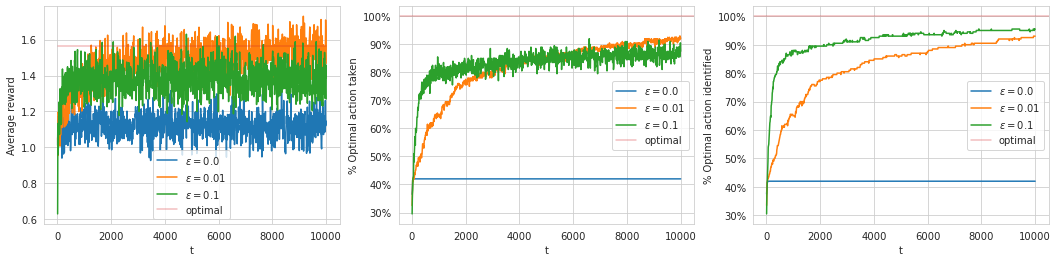

In [3]:
from functools import partial
from bandits import bandit_experiment, BanditResults
from rl.environments.bandit import random_bandit
from rl.agents import EpsilonGreedyRewardAveragingAgent

# Set up experiment parameters
entropy = 238402285
n_levers = 10
agents_to_test = {
    fr"$\varepsilon = {epsilon}$": partial(EpsilonGreedyRewardAveragingAgent, epsilon, n_levers)
    for epsilon in [0.0, 0.01, 0.1]
}
bandit_builder = partial(
    random_bandit, n_levers, mean_params=(0.0, 1.0), sigma_params=(1.0, 0.0)
)
n_steps = 10000
test_bed_size = 200

# Load saved results, or if not found, run experiment. Then plot results.
results = bandit_experiment(
    agents_to_test,
    bandit_builder,
    test_bed_size,
    n_steps,
    logging_period=10,
    entropy=entropy,
    n_jobs=-1,
    verbose=1,
    results_file=f"results/epsilon-bandit-results-n_steps-{n_steps}-test_bed_size-{test_bed_size}.pkl",
)
results.plot()

The first two of these plots are analogous to the 2 charts in Figure 2.2 of the textbook (but with a testbed of 200 bandits instead of 2,000 and with simulations running for 10,000 steps instead of 1,000). The last plot shows how often the greedy action as estimated by the agent (i.e. the action that maximises estimated $Q$) corresponds to the actual optimal action. In all the plots, we have also added for context a horizontal pink line corresponding to the performance of an optimal agent that chooses the optimal action at every step.

We now return to answering the question.

Let's start with the case where $\varepsilon > 0$. In this case, as the simulation length goes to infinity, *all* states will be explored an infinite number of times and hence the agent's action value estimates for all states will converge to the true values. We can see this reflected in the righthand plot: the $\varepsilon = 0.1$ agent has typically identified the optimal action by around 6,000 steps; the $\varepsilon = 0.01$ agent will take much longer (as it will explore a given non-greedy action only approximately once every hundred steps) but will eventually get there.

However, although the higher $\varepsilon$ the quicker the optimal action is identified, it is also the cases that the higher $\varepsilon$ the more frequently the agent will fail to choose the optimal action (at least, if we keep $\varepsilon$ constant). This means that, in the long run, the average reward per step for an $\varepsilon$-greedy agent with non-zero $\varepsilon$ will ultimately converge to

$$(1 - \varepsilon)  R_\mathrm{opt} + \varepsilon R_\mathrm{random}$$

where $R_\mathrm{opt}$ is the expected reward-per-step for an agent that always selects the optimal action and $R_\mathrm{random}$ is the expected reward-per-step for an agent that always selects a random action. When we average over a large number of random bandits (whose mean rewards are drawn from a standard normal distribution and whose standard deviations are one, as specified in the book), then $R_\mathrm{random} = 0$ and

$$R_\mathrm{opt} = \mathbb{E}\left[\max(Z_1, Z_2, \ldots, Z_{10})\right]$$

where $Z_1, \ldots, Z_{10}$ are independent standard normal random variables. The pdf for the distribution for the max of these variables can be derived and the expectation numerically estimated as follows:

In [4]:
from scipy.stats import norm
from scipy.integrate import quadrature

# Since P(max(Z1, ..., Z10) < z) = P(Z1 < z & Z2 < z & ... & Z10 < z) = P(Z < z) ** 10
pdf = lambda z: 10. * (norm.cdf(z) ** 9) * norm.pdf(z)  # derivative of cdf
integrand = lambda z: z * pdf(z)
print("Expected reward for perfect agent: {:.3f} (error: {:.1e})".format(*quadrature(integrand, -10, 10, maxiter=1000)))


Expected reward for perfect agent: 1.539 (error: 1.6e-08)


Indeed, as shown by the dashed horizontal line in the first plot, the expected reward for the testbed used for the experiment is indeed around 1.5.

On the other hand, if $\varepsilon = 0$, i.e. the bandit is fully greedy, then it will in the long run settle on one action (which may not be the optimal) and stop trying any of the others. This happens when it has found an action for which the expected reward is greater by a safe margin than its (possibly wrong) action value estimates for the remaining actions. What counts as a safe margin depends on how many steps have been taken (since the weighting for the weight up date decreases as the step count grows). From the plots, it seems that the fully greedy agent only identifies the optimal action around one third of the time and as a result the average reward per step saturates at around 1 (i.e. a 30% loss on the optimal agent).

To conclude:
* In the long run, average reward per step is maximised by an agent with an $\varepsilon$ that is just greater than (but not equal to) zero. Its performance will tend to the optimal reward per step of around 1.5.
* However, the smaller $\varepsilon$ is set, the longer it will take for long-run conditions to be achieved.
* Hence, for practical purposes (i.e. given any finite limit on the number of steps that will be taken) there will be an optimal value of $\varepsilon$, which shrinks as the number of steps grows.
* On the other hand, even a small amount of exploration (e.g. $\varepsilon = 0.01$ in the plots) can quickly yield "good" rewards per step. Looking at the plots, although the $\varepsilon = 0.01$ agent does not reliably identify the optimal action even after 10,000 steps, it does quickly identify some "good enough" actions: by around 1,500 steps, it is already exceeding the average reward per step of the $\varepsilon = 0.1$ agent, despite not being as quick at identifying the truly optimal action.
* Of course, by starting $\varepsilon$ at a high number and shrinking it to zero, it is possible to get the best of both worlds: let the agent quickly identify the best action through extensive exploration and then let it always choose the optimal action by turning off exploration. However, this strategy would not work if the bandits were non-stationary (as discussed in later exercises).
* The $\varepsilon = 0$ fully greedy agent's performance saturates very quickly to a reward per step of around 1, because it never tries any other action once it has settled on action for which it has a good estimate of the value and that estimate exceeds its estimates for all the other actions (even if those other estimates are inaccurate).

### Exercise 2.4

Q: If the step-size parameters, $\alpha_n$, are not constant, then the estimate $Q_n$ is a weighted average of previously received rewards with a weighting different from that given by (2.6). What is the weighting on each prior reward for the general case, analogous to (2.6), in terms of the sequence of step-size parameters?

A: Recall the soft update rule for $Q_{n+1}$ — the value estimate for action $a$ to be used after this action has previously been taken $n$ times — is

$$ Q_{n + 1} = Q_n + \alpha_n \left[ R_n - Q_n \right]  $$

where $R_n$ is the reward received the last time action $a$ was taken. We can then show by induction that, in analogy with equation (2.6) of the textbook,

$$ Q_{n + 1} = \prod_{i=1}^n (1 - \alpha_i) Q_1 + \sum_{i=1}^n \alpha_i \prod_{j=i+1}^n (1 - \alpha_j) R_i,$$

where we use the [empty product](https://en.wikipedia.org/wiki/Empty_product) convention, i.e. $\prod_{i=n+1}^{n} p_i = 1$.

*Proof*. Base case ($n = 1$):

$$ Q_2 = (1 - \alpha_1) Q_1 + \alpha_1 R_1.$$

Inductive step ($n \to n+1$):

$$
\begin{align}
Q_{n+1} &= (1 - \alpha_n) \left[ \prod_{i=1}^{n-1} (1 - \alpha_i) Q_1 + \sum_{i=1}^{n-1} \alpha_i \prod_{j=i+1}^{n-1} (1 - \alpha_j) R_i \right]
           + \alpha_n R_n \\
        &= \prod_{i=1}^n (1 - \alpha_i) Q_1 + \sum_{i=1}^{n-1} \alpha_i \prod_{j=i+1}^{n} (1 - \alpha_j) R_i + \alpha_n R_n \\
        &= \prod_{i=1}^n (1 - \alpha_i) Q_1 + \sum_{i=1}^n \alpha_i \prod_{j=i+1}^n (1 - \alpha_j) R_i.
\end{align}
$$

### Exercise 2.5

Q: Design and conduct an experiment to demonstrate the difficulties that sample-average methods have for nonstationary problems. Use a modified version of the 10-armed testbed in which all the $q_*(a)$ start out equal and then take independent random walks... *(see textbook for remainder)*

A: Instead of pure random walks as specified in the book, we add a little bit of mean reversion in our experiments. This prevents $q_*(a)$ growing without bound, helping ensure that the identity of the optimal action keeps changing around - providing a stiffer test of the difference between sample averaging and exponentially weighted averaging for estimating action values.

The following code runs the experiment and plots the results:

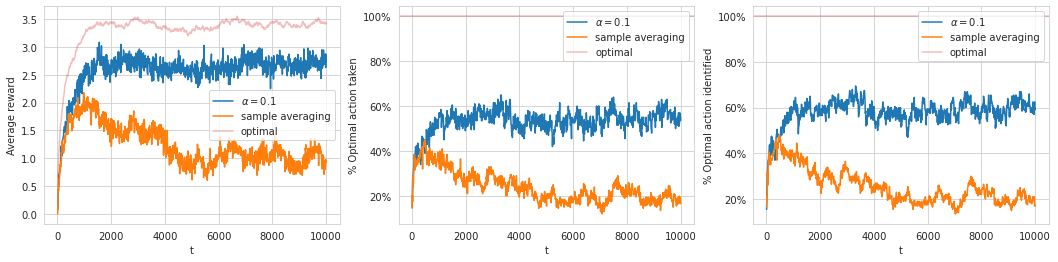

In [5]:
from functools import partial
import numpy as np
from bandits import bandit_experiment, BanditResults
from rl.environments.bandit import MultiArmedBandit
from rl.agents import EpsilonGreedyRewardAveragingAgent
from rl.learningrate import ConstantLearningRate


# Define mean reverting varying bandit
class MeanRevertingWalk:
    def __init__(self, theta, vol, random_state=None):
        self.theta = theta
        self.vol = vol
        self._rng = np.random.default_rng(random_state)
        
    def __call__(self, means, sigmas):
        return (means + self._rng.normal(loc=-self.theta * means, scale=self.vol, size=means.shape)), sigmas


def mean_reverting_varying_bandit(means, sigmas, theta, vol, random_state):
    return MultiArmedBandit(
        means,
        sigmas,
        state_updater=MeanRevertingWalk(theta, vol, random_state=random_state),
        random_state=random_state,
    )

# Set up experiment parameters
entropy = 5678942
epsilon = 0.1
n_levers = 10
means, sigmas = [0.] * n_levers, [1.] * n_levers
theta, vol = 0.001, 0.1
agents_to_test = {
    "sample averaging": partial(
        EpsilonGreedyRewardAveragingAgent, epsilon, n_levers
    ),
    fr"$\alpha = 0.1$": partial(
        EpsilonGreedyRewardAveragingAgent, epsilon, n_levers, learning_rate_schedule=ConstantLearningRate(0.1)
    ),
}
bandit_builder = partial(mean_reverting_varying_bandit, means, sigmas, theta, vol)
n_steps = 10000
test_bed_size = 200

# Load saved results, or if not found, run experiment. Then plot results.
results = bandit_experiment(
    agents_to_test,
    bandit_builder,
    test_bed_size,
    n_steps,
    logging_period=10,
    entropy=entropy,
    n_jobs=-1,
    verbose=1,
    results_file=f"results/nonstationary-bandit-results-n_steps-{n_steps}-test_bed_size-{test_bed_size}-theta-{theta}-vol-{vol}.pkl",
)
results.plot()

From the charts we can clearly see that as time passes, sample averaging clearly suffers from bias: because it equally weights experiences from early in the simulation, its action value estimates only identify the correct optimal action around 20% of the time after a while.

### Exercise 2.6

Q: The results shown in Figure 2.3 should be quite reliable because they are averages over 2000 individual, randomly chosen 10-armed bandit tasks. Why, then, are there oscillations and spikes in the early part of the curve for the optimistic method? In other words, what might make this method perform particularly better or worse, on average, on particularly early steps?

A: Figure 2.3 in the textbook compares a fully greedy agent with optimistic initial action value estimates ($Q_1 = 5$) against an $\varepsilon$-greedy agent with unbiased initial action value estimates ($Q_0 = 0$). Let's begin by reproducing this figure, as follows:

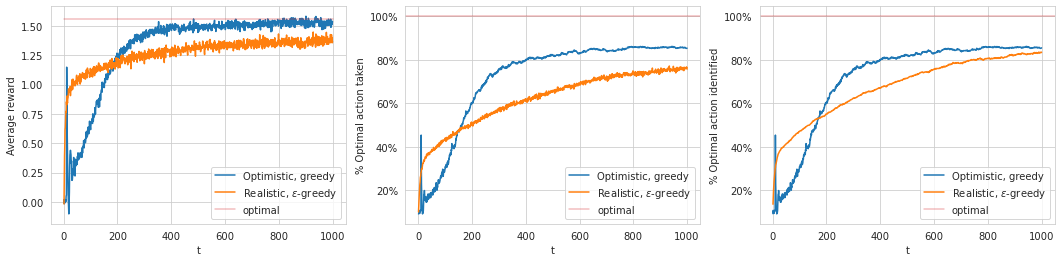

In [6]:
from functools import partial
from bandits import bandit_experiment, BanditResults
from rl.environments.bandit import random_bandit
from rl.agents import EpsilonGreedyRewardAveragingAgent
from rl.learningrate import ConstantLearningRate

# Set up experiment parameters
entropy = 2349053634
alpha = 0.1
n_levers = 10
agents_to_test = {
    "Optimistic, greedy": partial(
        EpsilonGreedyRewardAveragingAgent,
        epsilon=0.0,
        n_actions=n_levers,
        learning_rate_schedule=ConstantLearningRate(alpha),
        initial_action_values = [5.0] * n_levers,
    ),
    r"Realistic, $\varepsilon$-greedy": partial(
        EpsilonGreedyRewardAveragingAgent,
        epsilon=0.1,
        n_actions=n_levers,
        learning_rate_schedule=ConstantLearningRate(alpha),
        initial_action_values = [0.0] * n_levers,
    ),
}
bandit_builder = partial(
    random_bandit, n_levers, mean_params=(0.0, 1.0), sigma_params=(1.0, 0.0)
)
n_steps = 1000
test_bed_size = 2000

# Load saved results, or if not found, run experiment. Then plot results.
results = bandit_experiment(
    agents_to_test,
    bandit_builder,
    test_bed_size,
    n_steps,
    logging_period=1,
    entropy=entropy,
    n_jobs=-1,
    verbose=1,
    results_file=f"results/optimistic-initial-values-results-n_steps-{n_steps}-test_bed_size-{test_bed_size}.pkl",
)
results.plot()

Of these, the middle plot corresponds to Figure 2.3 in the book. There is a clear spike in performance at step 11 followed by a dip, with performance rising again from around step 20. We can zoom in below to check this:

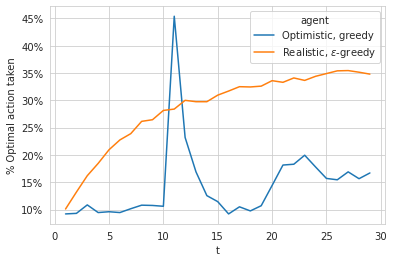

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
sns.set_style("whitegrid")
sns.lineplot(data=results.summary().query("t < 30"), x="t", y="prob_action_taken_optimal", hue="agent")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0, decimals=0))
plt.ylabel("% Optimal action taken");

To understand this, it is first important to realise that the initial action values for the optimistic agent, at $Q_1 = 5$ are significantly greater than the typical optimal reward for bandits in this testbed (recall from above that this is around 1.5). As a result, for the first 10 steps the agent will simply try each action in turn at random (i.e. with a probability of the optimal action being chosen being 10% at each of these first 10 steps). Thus we see that the blue curve in the graph above stays at around 10% for the first ten steps.

After this, on the 11th step, the agent has now tried each action and therefore all the $Q(a)$ will have been revised down (because none of them will be as high as the initial estimate). The $Q(a)$ that typically will have been revised down the least will be the one corresponding to the optimal action (as the agent would typically have received the highest reward for this action). Therefore, there is a good probability that on step 11 the agent will choose the optimal action (around 45% of the time, according to the graph above).

Why does performance drop again after step 11? Well, if the agent chooses the optimal action at step 11, the action value estimate for this action will drop even further down from its initial value of 5. This means the action value estimates for the remaining actions (which were not chosen, and are only a little bit less than 5) are now likely to exceed the estimate for the optimal action. Therefore it is unlikely that the optimal action will be chosen again straight after step 11 as other actions are instead chosen (and their corresponding $Q(a)$ are updated).

Eventually, around step 20, all the action value estimates have settled in a reasonable range (not overly optimistic) and the agent can start learning reliably. Thus from around step 20 onwards, the optimistic agent learns steadily.

Although the optimistic agent starts off learning more slowly than a greedy agent, the rate at which it learns is steep after this initial "burn-in" phase and it quickly overtakes the greedy agent. This is because the exploration of all actions it was forced to do at the start means it has a better idea of the values of all the actions than the greedy agent (which, as we saw above, quickly stops trying any other actions than the one it has settled on as the greedy action).

Nevertheless, as discussed in the book, setting an optimistic initial value is really a "trick" that has limited general applicability. It does not help with non-static problems.

### Exercise 2.7

Q: In most of this chapter we have used sample averages to estimate action values because sample averages do not produce the initial biases that constant step sizes do. However, sample averages are not a completely satisfactory solution because they may perform poorly on nonstationary problems. Is it possible to avoid the bias of constant step sizes while retaining their advantages on nonstationary problems? One way is to use a step size of

$$\beta_n \doteq \alpha / \bar{o}_n,$$

to process the $n$th reward for a particular action, where $\alpha > 0$ is a convential constant step size, and $\bar{o}_n$ is a trace of one that starts at 0:

$$\bar{o}_n \doteq \bar{o}_{n-1} + \alpha(1 - \bar{o}_{n-1}),
\quad\mathrm{for~}n \geq 0,\quad\mathrm{with~}\bar{o}_0 \doteq 0.$$

Carry out an analysis ... to show that $Q_n$ is an exponential recency-weighted average *without initial bias*.

A: We begin by making the replacement $\alpha_i \to \beta_i = \alpha / \bar{o}_i$ to the closed-form expression for $Q_{n+1}$ derived in Exercise 2.4 above to find that:

$$
\begin{align}
Q_{n+1} &= \prod_{i=1}^n (1 - \beta_i) Q_1 + \sum_{i=1}^n \beta_i \prod_{j=i+1}^n (1 - \beta_j) R_i \\
 &= \sum_{i=1}^n \beta_i \prod_{j=i+1}^n (1 - \beta_j) R_i .\\
\end{align}$$

Note that the second line follows because $\beta_1 = 1$ according to the definitions of $\beta_i$ and $\bar{o}_i$ given in the question, causing the product that multiplies $Q_1$ to vanish. It immediately follows that — as desired — none of the $Q_i$, for $i \geq 2$, depend on initial action value estimates $Q_1$.

However, to fully answer the question, we need to show further that $Q_{n+1}$ is an *exponential recency-weighted* average of the $R_1, R_2 \ldots R_n$. This is equivalent to showing that the coefficients in front of $R_i$ in the above expression form a increasing geometric progression, i.e. to show that these coefficients

$$c_i \doteq \beta_i \prod_{j=i+1}^{n} (1 - \beta_j) $$

satisfy

$$\frac{c_{i}}{c_{i-1}} = r\quad \mathrm{for~} i=2 \cdots n \quad\mathrm{where~} r > 1.$$

Now

$$
\frac{c_{i}}{c_{i-1}} = \frac{\beta_i}{\beta_{i-1}} \frac{\prod_{j=i+1}^{n} (1 - \beta_j)}{\prod_{j=i}^{n} (1 - \beta_j)}
 = \frac{\beta_i}{\beta_{i-1}(1 - \beta_i)}.$$
 
Substituting in the definition of $\beta_i$ and simplifying we therefore find that
$$
\frac{c_{i}}{c_{i-1}} = \frac{\bar{o}_{i-1}}{\bar{o}_i (1 - \tfrac{\alpha}{\bar{o}_i})} = \frac{\bar{o}_{i-1}}{\bar{o}_i - \alpha}.
$$

Since, by definition, $\bar{o}_{i} = \alpha + (1 - \alpha) \bar{o}_{i-1}$ we therefore find that

$$
\frac{c_{i}}{c_{i-1}} = \frac{1}{1 - \alpha} > 1,
$$

thus demonstrating that the $c_i$ form an increasing geometric progression as required.

#### An alternative perspective

We have now answered the question, but none of the above seems particularly intuitive. How did someone have the idea in the first place that defining $\bar{o}_n$ and $\beta_n$ as above would yield an exponential recency-weighted average of past rewards unbiased by any initial estimate? Let's consider how we might naively try to solve this problem, the challenges we would encounter, and hence see if we can re-derive the approach defined in the question.

Recall, the challenge is to find a recursive update formula for $Q_{n+1}$ that corresponds to exponential recency-weighted averaging of past rewards *without* any reliance on an initial value estimate $Q_1$. Naively, we might be tempted to take the following approach:

$$ Q_{n+1} \overset{?}{=}
\begin{cases}
\alpha R_{n} + (1 - \alpha) Q_n, & \textrm{if } n > 2 \\
\alpha R_{n}, & \textrm{if } n = 1,
\end{cases}
$$

Or, equivalently, to say that it is sufficient to always force $Q_1 = 0$ and use the standard update rule defined in the textbook. After all, as per equation (2.6) in the textbook, both these approaches would lead to the following closed expression for $Q_{n+}$ which does look very much like exponential recency-weighted averaging of past rewards:

$$ Q_{n+1} \overset{?}{=} \alpha R_n + \alpha (1 - \alpha) R_{n-1} + \cdots + \alpha (1 - \alpha)^{n-1} R_1. $$

So what is wrong with that suggestion? The trouble is that this closed expression is not a true weighted mean of past rewards unless the weights sum to one. In fact, using the standard formula for a geometric series, we see that the sum of the weights is

$$ \sum_{i=1}^{n}\alpha(1 - \alpha)^{n-1} = 1 - (1 - \alpha)^n$$

which does not equal one for $\alpha < 1$.

As a result, $Q_{n+1}$ calculated in this way is a biased estimator of the expected reward:

$$\textrm{bias} = \mathbb{E}\left[Q_{n+1}\right] - \mathbb{E}\left[R\right]
 = - (1 - \alpha)^n \mathbb{E}\left[R\right] \neq 0.$$

How can we remove this bias? The obvious approach is to renormalise the weights so that they *do* sum up to one, i.e. to define

$$Q_{n+1} \doteq \frac{\alpha R_n + \alpha (1 - \alpha) R_{n-1} + \cdots + \alpha (1 - \alpha)^{n-1} R_1}{1 - (1 - \alpha)^n}.$$

This is now a valid (i.e. unbiased) exponential recency-weighted average of the previous $n$ rewards, as desired.

The only trouble is that $Q_{n+1}$ is now expressed in closed form, instead of as a recurrence relation. This is undesirable as we do not want to have to keep of all previous rewards to update $Q$. To turn this into a recurrence relation, we start by substituting the closed from expression for $Q_n$ into the above expression for $Q_{n+1}$:

$$
\begin{align}
Q_{n+1} &\doteq \frac{\alpha R_n + (1 - \alpha) \left(1 - (1 - \alpha)^{n-1}\right)Q_n}{1 - (1 - \alpha)^n} \\
 &= \frac{\alpha}{1 - (1 - \alpha)^n} R_n + \left[1 - \frac{\alpha}{1 - (1 - \alpha)^n}\right] Q_n\\
 &= \beta_n R_n + (1 - \beta_n) Q_n.
\end{align}
$$

where

$$\beta_n \doteq \frac{\alpha}{1 - (1 - \alpha)^n}.$$

All that remains to recover the update scheme defined in the question is to recast the denominator $\bar{o}_n \doteq 1 - (1 - \alpha)^n$ into another recurrence relation. Again we do this by comparing closed expressions for $\bar{o}_n$ and $\bar{o}_{n-1}$:

$$1 - \bar{o}_n = (1 - \alpha) (1 - \bar{o}_{n-1}),$$

Which we can rearrange to define $\bar{o}_n$ in terms of the recurrence relations

$$\bar{o}_n \doteq \alpha + (1 - \alpha) \bar{o}_{n-1}, \quad \bar{o}_0 = 0.$$

#### Is this actually useful?

We have derived an update scheme for $Q_{n+1}$ that corresponds to exponential recency-weighted averaging of past rewards without any dependence on an initial estimate $Q_1$. In practice, how useful is this scheme compared to the simple (but biased) constant-$\alpha$ update rule defined in the textbook?

The answer, unsurprisingly, is that — while this unbiased update rule may be theoretically nice — in practice it will not yield significantly different results from the standard (constant-$\alpha$) update rule. We can see this by looking at the ratio between the learning parameters for the two update rules, i.e. the ratio $\alpha / \beta_n$, which in turn is given by $\bar{o}_n = 1 - (1 - \alpha)^n$. From this expression it is clear that this ratio converges exponentially quickly to 1, with a time constant (for small $\alpha$) of the order of $\alpha^{-1}$. In other words, for $\alpha$ (say) set to 0.1, the two update rules are not going to differ significantly after the first few dozen steps.

Another way to see this is to look at the bias of the simple constant-$\alpha$ update rule. For a stationary problem, this bias is given by

$$
\begin{align}
\mathbb{E}\left[Q_{n+1}\right] - \mathbb{E}\left[R\right]
 &= (1 - \alpha)^n Q_1 + \left[\sum_{i=1}^{n} \alpha (1 - \alpha)^{n - i} - 1\right] \mathbb{E}\left[R\right] \\
 &= (1 - \alpha)^n \left(Q_1 - \mathbb{E}\left[R\right]\right).
\end{align}
$$

Again, this shows that, while the constant-$\alpha$ update rule is biased (unless we cleverly pick $Q_1 = \mathbb{E}\left[R\right]$, though in that case we do not need this estimator in the first place!), this bias vanishes exponentially quickly over the order of $\alpha^{-1}$ steps. Therefore, for all practical purposes, we may as well stick with the simpler constant-$\alpha$ update rule.

### Exercise 2.8

Q: In Figure 2.4 the UCB algorithm shows a distinct spike in performance on the 11th step. Why is this?

A: Figure 2.4 is a comparison between Upper Confidence Bound (UCB) action selection and $\varepsilon$-greedy action selection. Let us begin by reproducing this comparison by running the experiment below:

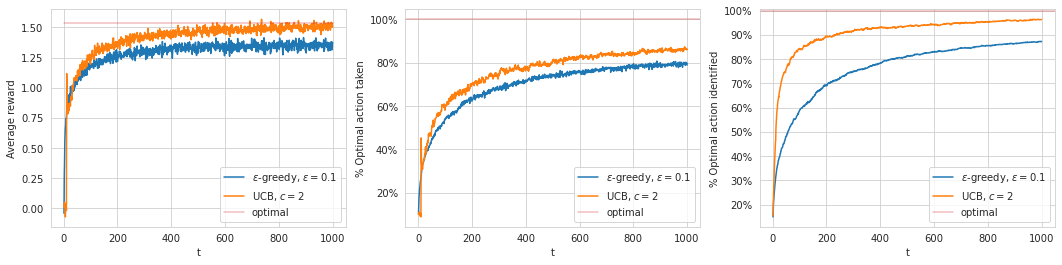

In [8]:
from functools import partial
from bandits import bandit_experiment, BanditResults
from rl.environments.bandit import random_bandit
from rl.agents import EpsilonGreedyRewardAveragingAgent, UCBRewardAveragingAgent

# Set up experiment parameters
entropy = 32094239
c = 2.0
n_levers = 10
agents_to_test = {
    r"UCB, $c=2$": partial(
        UCBRewardAveragingAgent, c=c, n_actions=n_levers
    ),
    r"$\varepsilon$-greedy, $\varepsilon = 0.1$": partial(
        EpsilonGreedyRewardAveragingAgent, epsilon=0.1, n_actions=n_levers
    ),
}
bandit_builder = partial(
    random_bandit, n_levers, mean_params=(0.0, 1.0), sigma_params=(1.0, 0.0)
)
n_steps = 1000
test_bed_size = 2000

# Load saved results, or if not found, run experiment. Then plot results.
results = bandit_experiment(
    agents_to_test,
    bandit_builder,
    test_bed_size,
    n_steps,
    logging_period=1,
    entropy=entropy,
    n_jobs=-1,
    verbose=1,
    results_file=f"results/ucb-results-c-{c}-n_steps-{n_steps}-test_bed_size-{test_bed_size}.pkl",
)
results.plot()

The spike at step 11 can clearly be seen in the plots above.

To see why this happens it is first helpful to recall how UCB action selection works: the action at time step $t$ is chosen according to the formula

$$
A_t \doteq \underset{a}{\operatorname{arg\,max}}\left[Q_t(a) + c \sqrt{\frac{\log t}{N_t(a)}}\right]
$$

where $Q_t(a)$ is the action value estimate for action $a$ at the beginning of this time step; and $N_t(a)$ is the number of times action $a$ has previously been taken by the beginning of this time step.

From this formula it is clear that, for the first 10 time steps, each of the 10 available actions will be taken in turn (in a random order), since when $N_t(a) = 0$, the upper confidence bound for action $a$ is infinite (or a very large number in the numerical implementation).

This means that, by step 11, all the available actions have been tried exactly once. Furthermore, with each action having been tried once, $Q_{11}(a)$ is now an unbiased estimate of each action's value. Hence, averaged over many testbeds, the optimal action is more likely than any other to be selected at step 11, resulting in a sudden jump in performance.

On step 12 however, $N_{12}(a)$ will be 2 for the action that was selected at step 11 but 1 for all remaining actions. This means that, if the optimal action was chosen at step 11, the UCB formula will suppress this action for step 12 (and the following few steps) in favour of trying out one of the other actions (for which $N_t(a)$ is still one). Hence, following step 11 there is an immediate drop in performance again.

Eventually, as all the $N_t(a)$ grow, the ordering of UCBs is determined largely by $Q_t(a)$ and learning stabilises. How quickly happens depends on the parameter $c$: if $c$ is large, exploration happens for longer before learning settles down, possibly resulting in multiple spikes before learning settles down.

### Exercise 2.9

Q: Show that in the case of two actions, the soft-max distribution is the same as that given by the logistic, or sigmoid, function often used in statistics and artificial intelligence.

A: The soft-max (aka Gibbs or Boltzmann) distribution is a distribution over a discrete space $\mathcal{A}$ with probabilities defined as follows:

$$
\operatorname{Pr}\left[A=a\right] \doteq \frac{e^{H(a)}}{\sum_{a' \in \mathcal{A}} e^{H(a')}}
$$

For a given energy function $H: \mathcal{A} \to \mathbb{R}$.

If $|\mathcal{A}| = 2$ and, without loss of generality, we suppose $\mathcal{A} = \left\{0, 1\right\}$, then this means

$$
\operatorname{Pr}\left[A=1\right] = \frac{e^{H(1)}}{e^{H(0)} + e^{H(1)}}
 = \frac{1}{1 + e^{H(0) - H(1)}}
 = \sigma\left(H(1) - H(0)\right)
$$

where $\sigma(x) \doteq (1 + e^{-x})^{-1}$ is the sigmoid function.

#### Two more observations about the Boltzmann distribution

Firstly note that the distribution is not uniquely specified: energy functions $H(a)$ and $\tilde{H}(a) \doteq H(a) + c$ (where $c$ is an arbitrary constant) yield identical distributions, since

$$
\frac{e^{\tilde{H}(a)}}{\sum_{a' \in \mathcal{A}} e^{\tilde{H}(a')}}
 = \frac{e^c e^{H(a)}}{\sum_{a' \in \mathcal{A}} e^c e^{H(a')}}
 = \frac{e^{H(a)}}{\sum_{a' \in \mathcal{A}} e^{H(a')}}.
$$

Secondly note that, in fact, *any* discrete probability distribution over $\mathcal{A}$ can be specified as a Boltzmann distribution with an appropriately chosen energy function. Defining $\pi(a) \doteq \operatorname{Pr}\left[A=a\right]$, we simply need to make the identification $H(a) = \log \pi(a)$, since

$$
\frac{e^{H(a)}}{\sum_{a' \in \mathcal{A}} e^{H(a')}}
 = \frac{e^{\log \pi(a)}}{\sum_{a' \in \mathcal{A}} e^{\log \pi(a')}}
 = \frac{\pi(a)}{\sum_{a' \in \mathcal{A}} \pi(a')}
 = \pi(a)
$$

This means that we should really consider the Boltzmann distribution as a different way to parameterise an arbitrary probability distribution: we specify the distribution by defining the energy function $H(a)$ instead of the probabilities $\pi(a)$.

What is the benefit of specifying a probability distribution in this way? Well, one benefit is that $\pi(a)$ has to satisfy various constraints to define a valid probability distribution: it needs to take values in the interval $[0, 1]$ and furthermore sum to one. On the other hand, any energy function $H: \mathcal{A} \to \mathbb{R}$ will define a valid probability distribution. This has its advantages when we wish to use an optimisation algorithm to solve for an "optimal" probability distribution for a given problem: optimising $H$ is an unconstrained optimisation problem.

### Additional Exercise

Q: Reproduce Figure 2.5 in the book, comparing performance of the gradient bandit algorithm, with and without a good baseline.

A: We perform a slightly different experiment from the results plotted in the book (but with ultimately the same consequences). We set up gradient bandit agents that either use average historical reward ($\bar{R}_t$ in the book's notation) as a baseline, or the constant $-4$ as the baseline. In both cases we use the same testbed as for the experiments above (i.e. where the average reward across all levers is expected to be around zero).

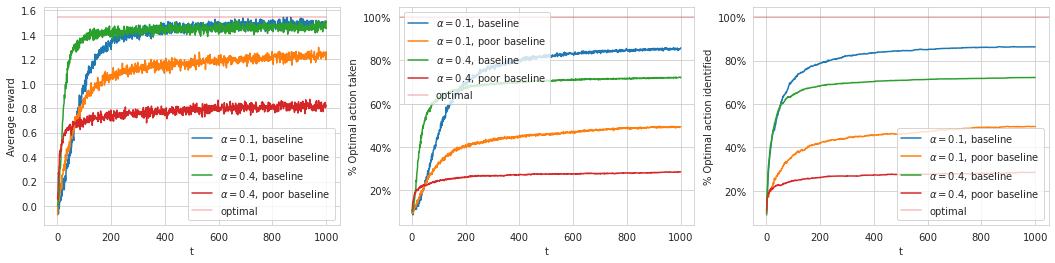

In [9]:
from functools import partial
from bandits import bandit_experiment, BanditResults
from rl.environments.bandit import random_bandit
from rl.agents import GradientBanditAgent

# Set up experiment parameters
entropy = 275328045
n_levers = 10
agents_to_test = {
    r"$\alpha=0.1$, baseline": partial(GradientBanditAgent, 0.1, n_levers),
    r"$\alpha=0.1$, poor baseline": partial(GradientBanditAgent, 0.1, n_levers, baseline=-4.0),
    r"$\alpha=0.4$, baseline": partial(GradientBanditAgent, 0.4, n_levers),
    r"$\alpha=0.4$, poor baseline": partial(GradientBanditAgent, 0.4, n_levers, baseline=-4.0),
}
bandit_builder = partial(
    random_bandit, n_levers, mean_params=(0.0, 1.0), sigma_params=(1.0, 0.0)
)
n_steps = 1000
test_bed_size = 2000

# Load saved results, or if not found, run experiment. Then plot results.
results = bandit_experiment(
    agents_to_test,
    bandit_builder,
    test_bed_size,
    n_steps,
    logging_period=1,
    entropy=entropy,
    n_jobs=-1,
    verbose=1,
    results_file=f"results/gradient-results-n_steps-{n_steps}-test_bed_size-{test_bed_size}.pkl",
)
results.plot()

Note that it is the middle graph that corresponds to Figure 2.5 from the textbook.

### Exercise 2.10

Q: Suppose you face a 2-armed bandit task whose true action values change randomly from time step to time step. Specifically, suppose that, for any time step, the true values of actions 1 and 2 are respectively 0.1 and 0.2 with probability 0.5 (case A), and 0.9 and 0.8 with probability 0.5 (case B). If you are not able to tell which case you face at any step, what is the best expectation of success you can achieve and how should you behave to achieve it? Now suppose that on each step you are told whether you are facing case A or case B(although you still don't know the true action values). This is an associative search task. What is the best expectation of success you can achieve in this task, and how should you behave to achieve it?

A: Let's begin with the first question, i.e. where we cannot tell at any step whether the bandit is in mode A or mode B. This means that all we know is that by choosing action 1 we should expect a reward of $\tfrac{0.1 + 0.9}{2} = 0.5$, whereas by choosing action 2 we should expect a reward of $\tfrac{0.2 + 0.8}{2} = 0.5$. Since the expected reward is the same for either action, it doesn't matter what strategy we take to choose actions — irrespective of which action we take at each time step, our expected reward per step will be 0.5.

Now we turn to the second question, i.e. where we know at each step whether we are facing case A or case B. Under case A, action 2 is optimal, with expected reward of 0.2; under case B, action 1 is optimal, with expected reward of 0.9. So the optimal strategy is to select action 2 under case A and action 1 under case B. Since cases A and B arise with equal probability, under this optimal strategy our expected reward per step (averaged over many steps) is $\tfrac{0.2 + 0.9}{2} = 0.55$.